##### Imports

In [106]:
import asvFormula.bayesianNetworks.bayesianNetwork as bn
import asvFormula.experiments as exp
from asvFormula import asvRunResultsPath
from asvFormula.datasetManipulation import *
import asvFormula.exactASV as exact
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

childMeanASVFile = asvRunResultsPath + "/childASVAndShapleyMean.csv"
childExactASVFile = asvRunResultsPath + "/childASVAndShapleyExact.csv"
cancerExactASVFile = asvRunResultsPath + "/cancerASVAndShapleyExact.csv"
cancerMeanASVFile = asvRunResultsPath + "/cancerASVAndShapleyMean.csv"

#TODO: Fix the seed and the random so that I can reproduce the results. Right now it's not changing anything the seed method. 

In [107]:
from importlib import reload 
import asvFormula
import asvFormula.bayesianNetworks.bayesianNetwork as bn
import asvFormula.exactASV as exact

bn = reload(asvFormula.bayesianNetworks.bayesianNetwork)
exact = reload(asvFormula.exactASV)


### Running ASV for Cancer bayesian network

#### Train the decision tree model

In [108]:
BNmodel, variableToPredict, numberOfSamples, treeMaxDepth = exp.cancerNetworkConfig()

BNInference, valuesPerFeature, encodedDataset, dtTreeClassifier, dtAsNetwork = initializeDataAndRemoveVariable(BNmodel, variableToPredict, numberOfSamples, treeMaxDepth)

dataNoPrediction = encodedDataset.drop(variableToPredict, axis=1)
first_instance = dataNoPrediction.iloc[0]

  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.6916666666666667


#### Compute the ASV vs the Shapley Value

In [109]:
asvCalc = exact.ASV(BNmodel, dtTreeClassifier, BNInference, valuesPerFeature, variableToPredict, predictionFunction='Mean')

exp.writeASVAndShapleyIntoFile(first_instance, dataNoPrediction, dtTreeClassifier, asvCalc, cancerMeanASVFile , valuesPerFeature, variableToPredict)

In [110]:
asvCalc = exact.ASV(BNmodel, dtTreeClassifier, BNInference, valuesPerFeature, variableToPredict, predictionFunction = 'Exact')

exp.writeASVAndShapleyIntoFile(first_instance, dataNoPrediction, dtTreeClassifier, asvCalc, cancerExactASVFile, valuesPerFeature, variableToPredict)

### Running ASV for Child bayesian network

In [111]:
treeBNChild, variableToPredict, numberOfSamples, treeMaxDepth = exp.childNetworkConfig()

BNInference, valuesPerFeature, encodedDataset, dtTreeClassifier, dtAsNetwork = initializeDataAndRemoveVariable(treeBNChild, variableToPredict, numberOfSamples, treeMaxDepth)

dataNoPrediction = encodedDataset.drop(variableToPredict, axis=1)
first_instance = dataNoPrediction.iloc[0]

  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.667


#### ASV + Shapley

In [112]:
asvCalc = exact.ASV(treeBNChild, dtTreeClassifier, BNInference, valuesPerFeature, variableToPredict, predictionFunction = 'Mean')

exp.writeASVAndShapleyIntoFile(first_instance, dataNoPrediction, dtTreeClassifier, asvCalc, childMeanASVFile, valuesPerFeature, variableToPredict)

In [113]:
asvCalc = exact.ASV(treeBNChild, dtTreeClassifier, BNInference, valuesPerFeature, variableToPredict, predictionFunction='Exact')

exp.writeASVAndShapleyIntoFile(first_instance, dataNoPrediction, dtTreeClassifier, asvCalc, childExactASVFile, valuesPerFeature, variableToPredict)

#It takes 3 minutes to run

In [114]:
import shap
import timeit

timeTaken = timeit.timeit(lambda: shap.TreeExplainer(dtTreeClassifier, dataNoPrediction).shap_values(first_instance), number=1)
timeTaken

0.006260400001337985

## Plotting the results 

### Converting to numerical data

In [116]:
def dataframeFromCsv(path):
    df = pd.read_csv(path)
    df = df.iloc[:-1] #Remove last row, which is the sum
    df.name = path.split('/')[-1][:-4]
    return df

dfCancerMean = dataframeFromCsv(cancerMeanASVFile)
dfCancerExact = dataframeFromCsv(cancerExactASVFile)
dfChildMean = dataframeFromCsv(childMeanASVFile)
dfChildExact = dataframeFromCsv(childExactASVFile)

dataFramesToPlot = [dfCancerMean, dfCancerExact, dfChildMean, dfChildExact]

for column in ['ASV', 'Shapley']:
    for dataframe in dataFramesToPlot:
        dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')

### Plotting ASV values for each feature

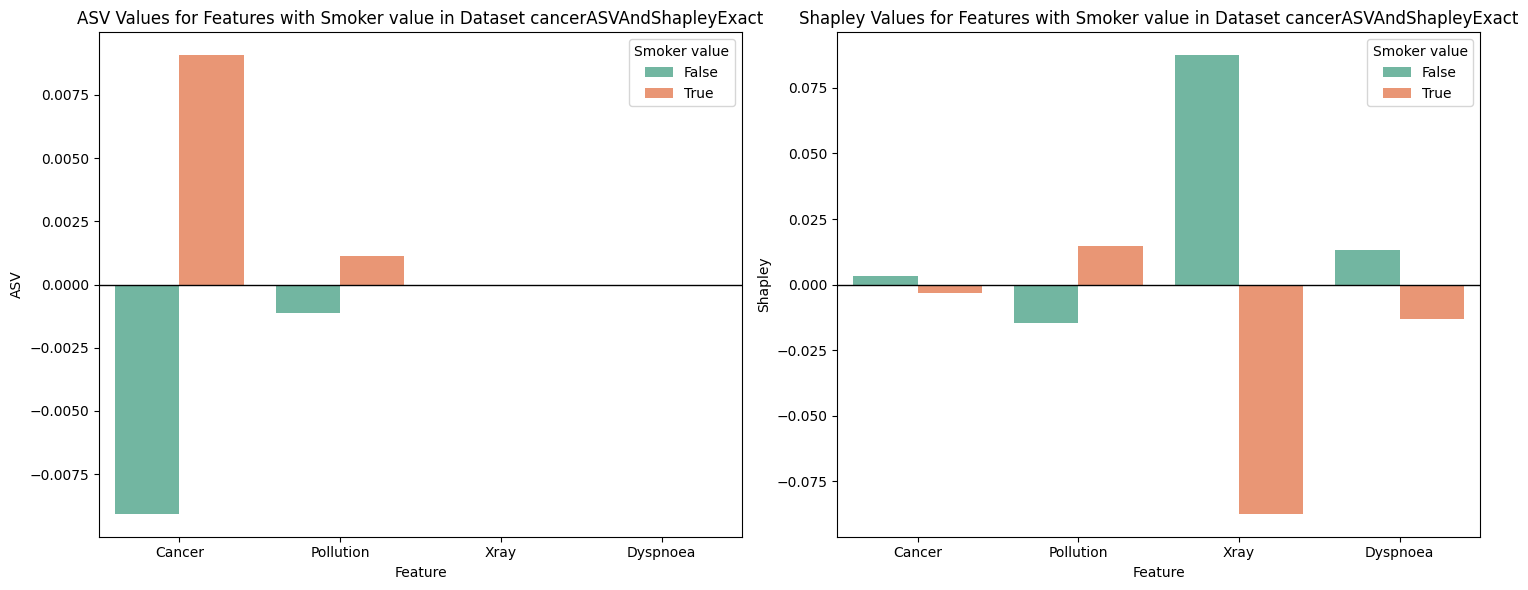

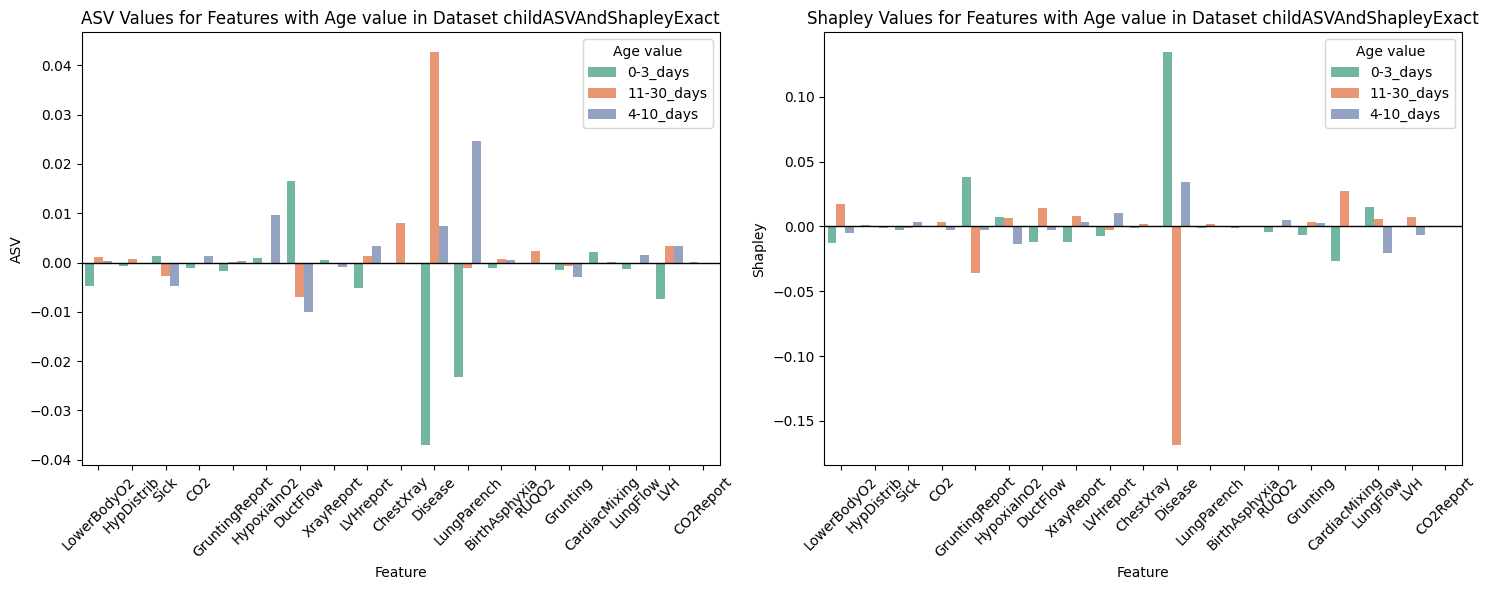

In [117]:
def plotValuesFromDF(ax, df, valueToPlot, hueValue, paletteValue='Set2'):
    sns.barplot(x="Feature", y=valueToPlot, hue=hueValue, data=df, palette=paletteValue, ax=ax)
    ax.axhline(0, color="black", linewidth=1)
    ax.set_title(f"{valueToPlot} Values for Features with {hueValue} in Dataset {df.name}")
    ax.set_ylabel(valueToPlot)
    ax.set_xlabel("Feature")
    if hueValue == 'Age value':
        ax.tick_params(axis='x', rotation=45)
    ax.legend(title=hueValue)


def plotASVandShapFromDF(df, hueValue):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    plotValuesFromDF(axes[0], df, 'ASV', hueValue)
    plotValuesFromDF(axes[1], df, 'Shapley', hueValue)
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


plotASVandShapFromDF(dfCancerExact, 'Smoker value')
plotASVandShapFromDF(dfChildExact, 'Age value')
